<a href="https://colab.research.google.com/github/shumshersubashgautam/Computer-Aided-Drug-Discovery-Learning/blob/main/1_query_chembl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/volkamerlab/teachopencadd.git

Cloning into 'teachopencadd'...
remote: Enumerating objects: 17115, done.
remote: Counting objects: 100% (2093/2093), done.
remote: Compressing objects: 100% (969/969), done.
remote: Total 17115 (delta 1309), reused 1786 (delta 1122), pack-reused 15022
Receiving objects: 100% (17115/17115), 849.77 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (11506/11506), done.
Updating files: 100% (468/468), done.


In this notebook, we will learn more about the ChEMBL database and how to extract data from ChEMBL, i.e. (compound, activity data) pairs for a target of interest. These data sets can be used for many cheminformatics tasks, such as similarity search, clustering or machine learning.

Our work here will include finding compounds that were tested against a certain target and filtering available bioactivity data.

# **Contents in Theory**
ChEMBL database

ChEMBL web services

ChEMBL web resource client

Compound activity measures

IC50 measure

pIC50 value

# **Contents in Practical**
Goal: Get a list of compounds with bioactivity data for a given target

Connect to ChEMBL database

Get target data (example: EGFR kinase)

Fetch and download target data

Select target ChEMBL ID

Get bioactivity data

Fetch and download bioactivity data for targets

Preprocess and filter bioactivity data

Get compound data

Fetch and download compound data

Preprocess and filter compound data

Output bioactivity-compound data

Merge bioactivity and compound data, and add pIC50 values

Draw molecules with highest pIC50

Freeze bioactivity data to ChEMBL 27

Write output file

# **References**
ChEMBL bioactivity database: Gaulton et al., Nucleic Acids Res. (2017), 45(Database issue), D945–D954
ChEMBL web services: Davies et al., Nucleic Acids Res. (2015), 43, 612-620
ChEMBL web-interface
GitHub ChEMBL web rescource client
The EBI RDF platform: Jupp et al., Bioinformatics (2014), 30(9), 1338-9
Info on half maximal inhibitory concentration: (p)IC50
UniProt website

# **ChEMBL database**
"ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs." (ChEMBL website)

Open large-scale bioactivity database
Current data content (as of 09.2020, ChEMBL 27):
>1.9 million distinct compounds
>16 million activity values
Assays are mapped to ~13,000 targets
Data sources include scientific literature, PubChem bioassays, Drugs for Neglected Diseases Initiative (DNDi), BindingDB database, ...
ChEMBL data can be accessed via a web-interface, the EBI-RDF platform and the ChEMBL web rescource client

# **Compound activity measures**
IC50 measure

Half maximal inhibitory concentration

Indicates how much of a particular drug or other substance is needed to inhibit a given biological process by half


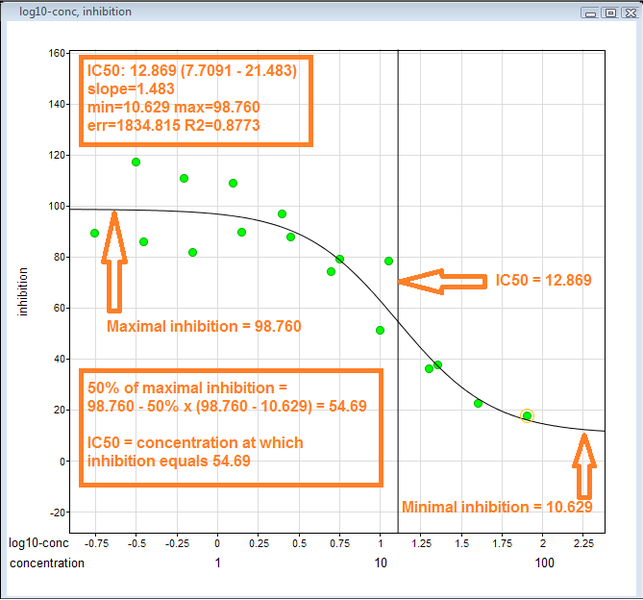
Figure 2: Visual demonstration of how to derive an IC50 value: (i) Arrange inhibition data on y-axis and log(concentration) on x-axis. (ii) Identify maximum and minimum inhibition. (iii) The IC50 is the concentration at which the curve passes through the 50% inhibition level. Figure "Example IC50 curve demonstrating visually how IC50 is derived" by JesseAlanGordon is licensed under CC BY-SA 3.0.

pIC50 value
To facilitate the comparison of IC50 values, which have a large value range and are given in different units (M, nM, ...), often pIC50 values are used
The pIC50 is the negative log of the IC50 value when converted to molar units:
, where
 is specified in units of M
Higher pIC50 values indicate exponentially greater potency of the drug
Note that the conversion can be adapted to the respective IC50 unit, e.g. for nM:
Other activity measures:

Besides, IC50 and pIC50, other bioactivity measures are used, such as the equilibrium constant KI and the half-maximal effective concentration EC50.

Practical
In the following, we want to download all molecules that have been tested against our target of interest, the epidermal growth factor receptor (EGFR) kinase.

Connect to ChEMBL database
First, the ChEMBL web resource client as well as other Python libraries are imported.

In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 45.8 MB/s eta 0:00:00


In [5]:
!pip install chembl-webresource-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0


In [6]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [7]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [8]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [9]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

# **Get target data (EGFR kinase)**
Get UniProt ID of the target of interest (EGFR kinase: P00533) from UniProt website
Use UniProt ID to get target information
Select a different UniProt ID, if you are interested in another target.

In [10]:
uniprot_id = "P00533"

Fetch target data from ChEMBL

In [11]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


**Download target data from ChEMBL**
The results of the query are stored in targets, a QuerySet, i.e. the results are not fetched from ChEMBL until we ask for it (here using pandas.DataFrame.from_records).

More information about the QuerySet datatype:

QuerySets are lazy – the act of creating a QuerySet does not involve any database activity. You can stack filters together all day long, and Django will actually not run the query until the QuerySet is evaluated.

(querysets-are-lazy)

In [12]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
5,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Baculoviral IAP repeat-containing protein 2/Ep...,CHEMBL4802031,PROTEIN-PROTEIN INTERACTION


# **Select target (target ChEMBL ID)**
After checking the entries, we select the first entry as our target of interest:

CHEMBL203: It is a single protein and represents the human Epidermal growth factor receptor (EGFR, also named erbB1)

In [13]:
target = targets.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

In [14]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL203


# **Get bioactivity data**
Now, we want to query bioactivity data for the target of interest.

Fetch bioactivity data for the target from ChEMBL
In this step, we fetch the bioactivity data and filter it to only consider

human proteins,
bioactivity type IC50,
exact measurements (relation '='), and
binding data (assay type 'B').

In [15]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 10420, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

In [16]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

Download bioactivity data from ChEMBL
Finally, we download the QuerySet in the form of a pandas DataFrame.

Note: This step should not take more than 2 minutes, if so try to rerun all cells starting from "Fetch bioactivity data for the target from ChEMBL" or read this message below:

Load a local version of the data (in case you encounter any problems while fetching the data)
If you experience difficulties to query the ChEMBL database, we also provide the resulting dataframe you will construct in the cell below. If you want to use the saved version, use the following code instead to obtain bioactivities_df

In [19]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

KeyboardInterrupt: ignored

Note that the first two rows describe the same bioactivity entry; we will remove such artifacts later during the deduplication step. Note also that we have columns for standard_units/units and standard_values/values; in the following, we will use the standardized columns (standardization by ChEMBL), and thus, we drop the other two columns.

If we used the units and values columns, we would need to convert all values with many different units to nM:

In [18]:
bioactivities_df["units"].unique()

NameError: ignored

In [ ]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

Preprocess and filter bioactivity data
Convert standard_value's datatype from object to float
Delete entries with missing values
Keep only entries with standard_unit == nM
Delete duplicate molecules
Reset DataFrame index
Rename columns
1. Convert datatype of "standard_value" from "object" to "float"

The field standard_value holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.